In [1]:
import matplotlib.pyplot as plt
import brainpy as bp
import brainpy.math as bm
from Model import Hierarchical_network
import numpy as np
bm.set(dt=0.05)

data = np.load('trajectory_int.npz')
    
# 提取各个矩阵
loc = data['position']
velocity = data['velocity']
speed = data['speed']
head_direction = velocity/speed[:,np.newaxis]
rot_vel = data['rot_vel']

Hierarchical_net = Hierarchical_network(num_module=5, num_place=30)

def initialize(i, input_stre):
    Hierarchical_net.step_run(i, velocity = bm.zeros(2,), loc=loc[0], loc_input_stre = input_stre)

init_time = 500
indices = bm.arange(init_time)
input_stre = bm.zeros(init_time) 
input_stre[:400] = 100.
bm.for_loop(initialize, (indices, input_stre), progress_bar=True)

def run(i, vel, loc):
    noise = bm.random.normal(0., 0.01, size=(2,))
    Hierarchical_net.step_run(i, velocity = vel+noise, loc=loc, loc_input_stre = 0.)
    place_fr = Hierarchical_net.place_fr
    grid_fr = Hierarchical_net.MEC_model_list[-1].Grid_cells.r
    Phase_true = Hierarchical_net.MEC_model_list[-1].Postophase(loc)
    Phase_grid = Hierarchical_net.MEC_model_list[-1].Grid_cells.center
    decoded_pos = Hierarchical_net.decoded_pos
    return place_fr, grid_fr, Phase_true, Phase_grid, decoded_pos

total_time = velocity.shape[0] 
indices = bm.arange(total_time)
place_fr, grid_fr, Phase_true, Phase_grid, decoded_pos = bm.for_loop(run, (indices, velocity, loc), progress_bar=True)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

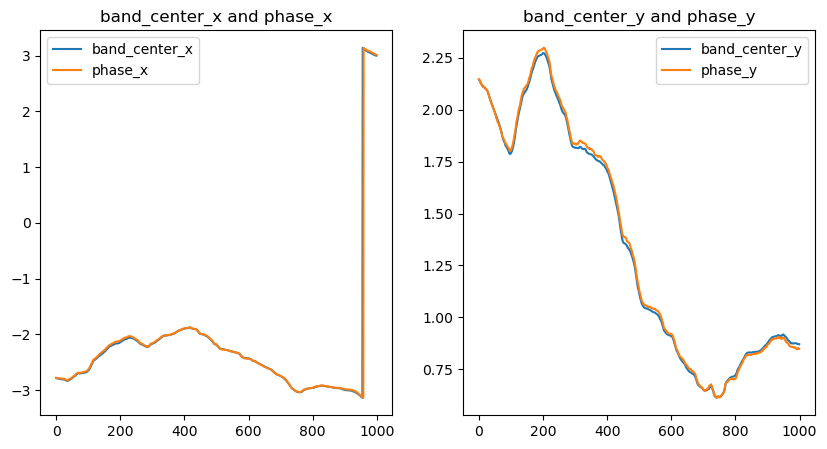

In [2]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(Phase_true[:,0], label='band_center_x')
plt.plot(Phase_grid[:,0], label='phase_x')
plt.title('band_center_x and phase_x')
plt.legend()
plt.subplot(122)
plt.plot(Phase_true[:,1], label='band_center_y')
plt.plot(Phase_grid[:,1], label='phase_y')
plt.title('band_center_y and phase_y')
plt.legend()

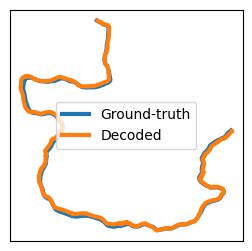

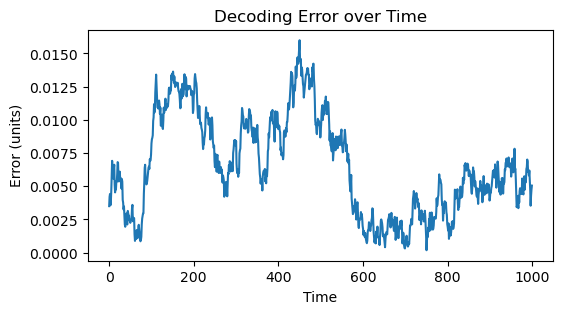

In [13]:
plt.figure(figsize=(3, 3))
plt.plot(loc[:,0], loc[:,1], label='Ground-truth', linewidth=3)
plt.plot(decoded_pos[:,0], decoded_pos[:,1], label='Decoded', linewidth=3)
# plt.title('decoded_pos and real_pos')
plt.xticks([])
plt.yticks([])
#放大legend字体 fontsize=16
plt.legend()
plt.savefig('decoded_pos.png', dpi=300, bbox_inches='tight')

error = bm.sqrt(bm.sum((decoded_pos - loc)**2, axis=1))
plt.figure(figsize=(6, 3))
plt.plot(error)
plt.title('Decoding Error over Time')
plt.xlabel('Time')
plt.ylabel('Error (units)')
plt.savefig('decoding_error.png', dpi=300, bbox_inches='tight')

(-3.4452800512313844,
 3.2358407735824586,
 -5.846480298042297,
 5.725560593605041)

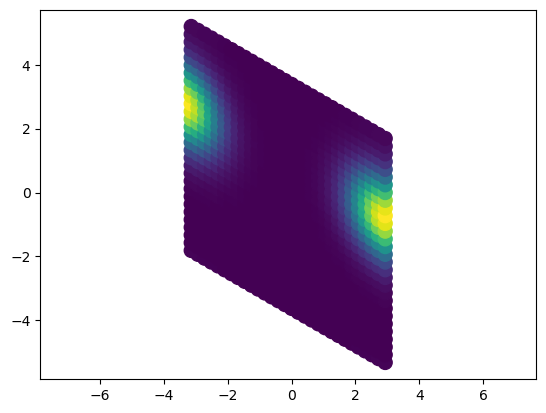

In [4]:
time = 999
value_grid = Hierarchical_net.MEC_model_list[-1].Grid_cells.value_grid
pos_grid = np.zeros_like(value_grid)
pos_grid[:,0] = value_grid[:,0]
pos_grid[:,1] = (value_grid[:,1] - 1/2 * value_grid[:,0]) * 2/bm.sqrt(3)
plt.figure()
plt.scatter(pos_grid[:, 0], pos_grid[:, 1], c=grid_fr[time,:], s=100)
plt.axis('equal')

[3.01489129 2.00071689]


(-0.25, 5.25, -0.25, 5.25)

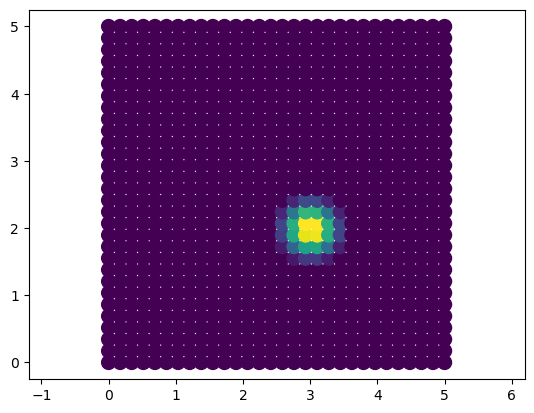

In [5]:
time = 990
print(loc[time])
place_center = Hierarchical_net.place_center
# from funcs import softmax
u = place_fr[time,:]
k = 1
r = u**2/(1+k*np.sum(u**2))
plt.figure()
plt.scatter(place_center[:, 0], place_center[:, 1], c= u, s=100)
plt.axis('equal')